# Notebook 3: Single-Cell Transcriptomics

**From raw counts to cell type discovery with scanpy**

Prerequisites: Notebooks 1-2 (sequence basics, variant analysis)

This notebook builds:
1. AnnData objects (the core data structure for single-cell)
2. Quality control: filtering dead cells, doublets, ambient RNA
3. Normalization and highly variable gene selection
4. Dimensionality reduction (PCA -> UMAP)
5. Clustering (Leiden algorithm)
6. Differential expression and marker gene identification
7. Cell type annotation

Estimated runtime: ~3 minutes (synthetic data, no downloads)

**Key learning outcomes:**
1. Understand single-cell RNA-seq as individual cell measurements (not tissue averages)
2. Build and manipulate AnnData objects -- see [[Hierarchical Composition]]
3. Apply the standard preprocessing pipeline (QC -> normalize -> HVG -> PCA -> UMAP)
4. Cluster cells and find marker genes -- see [[Trajectory and Branching Fate]]
5. Annotate cell types from markers -- see [[Context Conditionality]]

## Section 0: Setup

We use **scanpy** (Single-Cell Analysis in Python), the standard toolkit for single-cell genomics.
Like Qiskit provides circuit simulation for quantum computing, scanpy provides the complete
pipeline from raw counts to biological insight.

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sc.settings.verbosity = 1
sc.settings.set_figure_params(dpi=80, facecolor='white')
print(f"scanpy {sc.__version__}, anndata {ad.__version__} — ready")

scanpy 1.12, anndata 0.12.10 — ready


## Section 1: The AnnData Object

Single-cell RNA-seq measures the expression of ~20,000 genes in each of ~1,000-1,000,000
individual cells. The result is a sparse matrix: cells x genes.

The **AnnData** object organizes this data:
- `adata.X` -- the expression matrix (cells x genes)
- `adata.obs` -- cell metadata (cell type, sample, QC metrics)
- `adata.var` -- gene metadata (gene name, chromosome, highly variable flag)
- `adata.obsm` -- cell embeddings (PCA, UMAP coordinates)
- `adata.uns` -- unstructured data (color palettes, parameters)

$$X \in \mathbb{R}^{n_{cells} \times n_{genes}}, \quad \text{typically sparse (>90% zeros)}$$

See [[Hierarchical Composition]] -- AnnData captures the molecule-to-cell level of the
biological hierarchy.

In [2]:
# Simulate 3000 cells, 2000 genes, 5 cell types
np.random.seed(42)
n_cells = 3000
n_genes = 2000
n_types = 5

cell_type_names = ['T cells', 'B cells', 'Monocytes', 'NK cells', 'Dendritic']
cells_per_type = [800, 600, 700, 500, 400]

# Base expression (most genes off in most cells)
counts = np.random.negative_binomial(0.5, 0.5, (n_cells, n_genes)).astype(np.float32)

# Create cell type-specific marker genes
# Each cell type has ~20 marker genes with elevated expression
cell_labels = []
marker_genes = {}
row_idx = 0
for k, (name, n) in enumerate(zip(cell_type_names, cells_per_type)):
    cell_labels.extend([name] * n)
    # Assign marker genes
    start_gene = k * 30
    markers = list(range(start_gene, start_gene + 20))
    marker_genes[name] = markers

    # Boost expression of marker genes in this cell type
    for gene in markers:
        counts[row_idx:row_idx+n, gene] += np.random.poisson(15, n)
    row_idx += n

# Create gene names
gene_names = [f"GENE_{i:04d}" for i in range(n_genes)]
# Name some marker genes meaningfully
marker_labels = {
    'T cells': ['CD3D', 'CD3E', 'CD4', 'CD8A', 'IL7R', 'TCF7', 'LEF1', 'TRAC'],
    'B cells': ['CD19', 'MS4A1', 'CD79A', 'CD79B', 'PAX5', 'BANK1'],
    'Monocytes': ['CD14', 'LYZ', 'CST3', 'VCAN', 'FCN1', 'S100A8', 'S100A9'],
    'NK cells': ['NKG7', 'GNLY', 'KLRD1', 'KLRF1', 'PRF1', 'GZMA'],
    'Dendritic': ['FCER1A', 'CLEC10A', 'CD1C', 'IRF8', 'HLA-DRA'],
}

for k, (name, labels) in enumerate(marker_labels.items()):
    start = k * 30
    for i, label in enumerate(labels):
        gene_names[start + i] = label

# Create AnnData object
adata = ad.AnnData(
    X=counts,
    obs=pd.DataFrame({'cell_type': cell_labels}, index=[f'cell_{i}' for i in range(n_cells)]),
    var=pd.DataFrame(index=gene_names)
)

print(f"AnnData object: {adata}")
print(f"\nShape: {adata.shape[0]} cells x {adata.shape[1]} genes")
print(f"Cell types: {dict(zip(*np.unique(adata.obs['cell_type'], return_counts=True)))}")
print(f"\nadata.X (expression matrix):\n{adata.X[:3, :5]}")

AnnData object: AnnData object with n_obs × n_vars = 3000 × 2000
    obs: 'cell_type'

Shape: 3000 cells x 2000 genes
Cell types: {'B cells': np.int64(600), 'Dendritic': np.int64(400), 'Monocytes': np.int64(700), 'NK cells': np.int64(500), 'T cells': np.int64(800)}

adata.X (expression matrix):
[[14. 15.  8. 12.  9.]
 [20. 13.  9. 16. 16.]
 [17. 18. 11. 14. 16.]]


In [3]:
# Compute standard QC metrics
# Total counts per cell, genes detected per cell, % mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # No MT genes in our simulation
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print("QC metrics added to adata.obs:")
print(adata.obs[['total_counts', 'n_genes_by_counts']].describe())

QC metrics added to adata.obs:
       total_counts  n_genes_by_counts
count   3000.000000        3000.000000
mean    1299.679321         600.252000
std       48.986553          20.893652
min     1126.000000         528.000000
25%     1265.750000         586.000000
50%     1299.000000         600.000000
75%     1333.000000         614.000000
max     1483.000000         687.000000


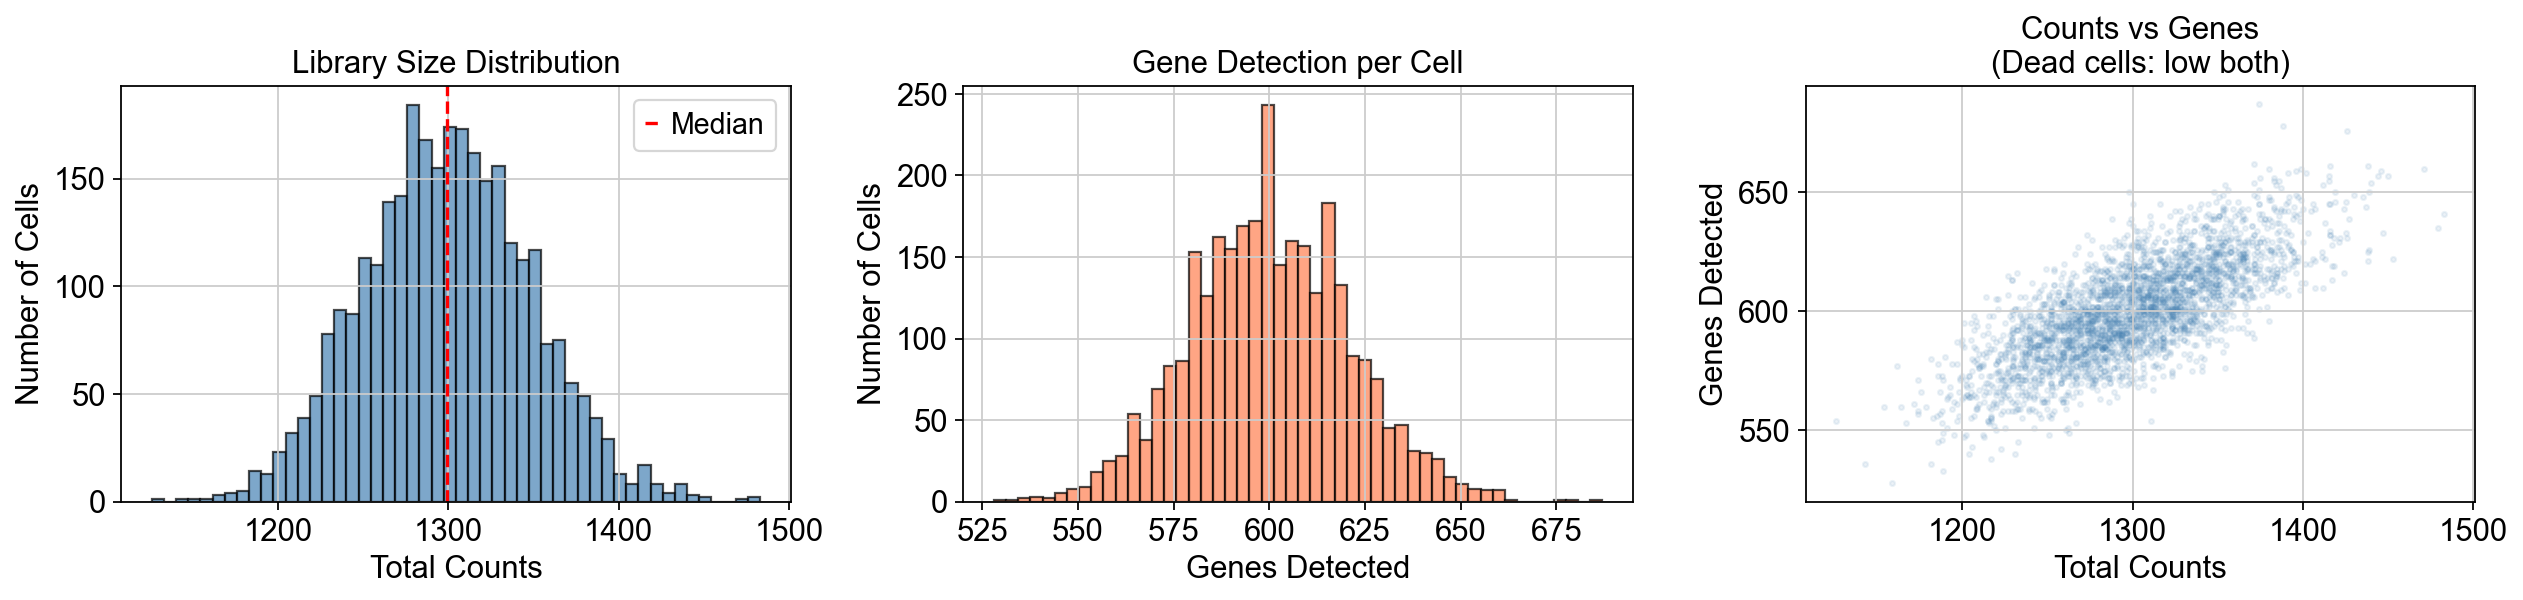

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].hist(adata.obs['total_counts'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Total Counts')
axes[0].set_ylabel('Number of Cells')
axes[0].set_title('Library Size Distribution')
axes[0].axvline(adata.obs['total_counts'].median(), color='red', linestyle='--', label='Median')
axes[0].legend()

axes[1].hist(adata.obs['n_genes_by_counts'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Genes Detected')
axes[1].set_ylabel('Number of Cells')
axes[1].set_title('Gene Detection per Cell')

axes[2].scatter(adata.obs['total_counts'], adata.obs['n_genes_by_counts'],
                alpha=0.1, s=5, color='steelblue')
axes[2].set_xlabel('Total Counts')
axes[2].set_ylabel('Genes Detected')
axes[2].set_title('Counts vs Genes\n(Dead cells: low both)')

plt.tight_layout()
plt.show()

## Section 2: Preprocessing Pipeline

The standard single-cell preprocessing pipeline:
1. **Filter** cells and genes (remove dead cells, doublets, lowly-expressed genes)
2. **Normalize** (library size + log1p transform)
3. **Select highly variable genes** (HVGs) -- most informative for clustering
4. **Scale** (zero-mean, unit-variance per gene)

This pipeline transforms raw UMI counts into a matrix suitable for PCA and clustering.
See [[Information Compression in Biology]] -- HVG selection is a form of lossy compression
that preserves biologically relevant variation.

In [5]:
# Filter cells and genes
print(f"Before filtering: {adata.shape}")

# Remove cells with too few genes
sc.pp.filter_cells(adata, min_genes=100)

# Remove genes expressed in too few cells
sc.pp.filter_genes(adata, min_cells=10)

print(f"After filtering: {adata.shape}")

Before filtering: (3000, 2000)
After filtering: (3000, 2000)


In [6]:
# Save raw counts for DE analysis later
adata.layers['counts'] = adata.X.copy()

# Library size normalization (each cell sums to 10,000)
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transform (reduces skewness, stabilizes variance)
sc.pp.log1p(adata)

print("Normalization complete: library size -> 10k, then log1p")
print(f"X range: [{adata.X.min():.2f}, {adata.X.max():.2f}]")

Normalization complete: library size -> 10k, then log1p
X range: [0.00, 5.66]


Highly variable genes: 1000


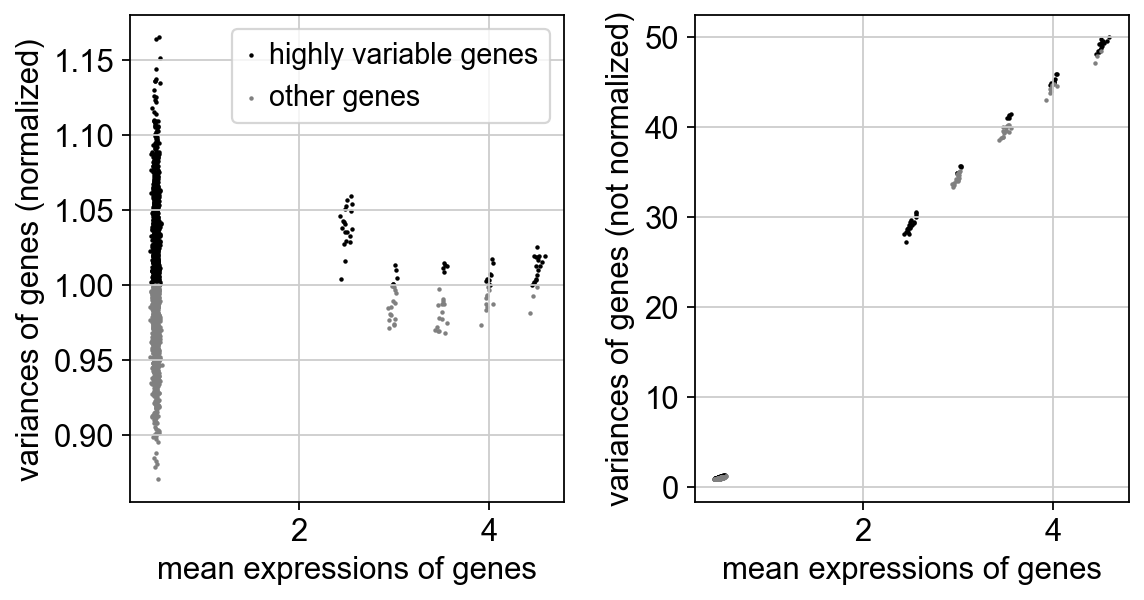

In [7]:
# Find highly variable genes (top ~1000)
sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='seurat_v3',
                             layer='counts')

print(f"Highly variable genes: {adata.var['highly_variable'].sum()}")

# Visualize HVG selection
sc.pl.highly_variable_genes(adata)
plt.show()

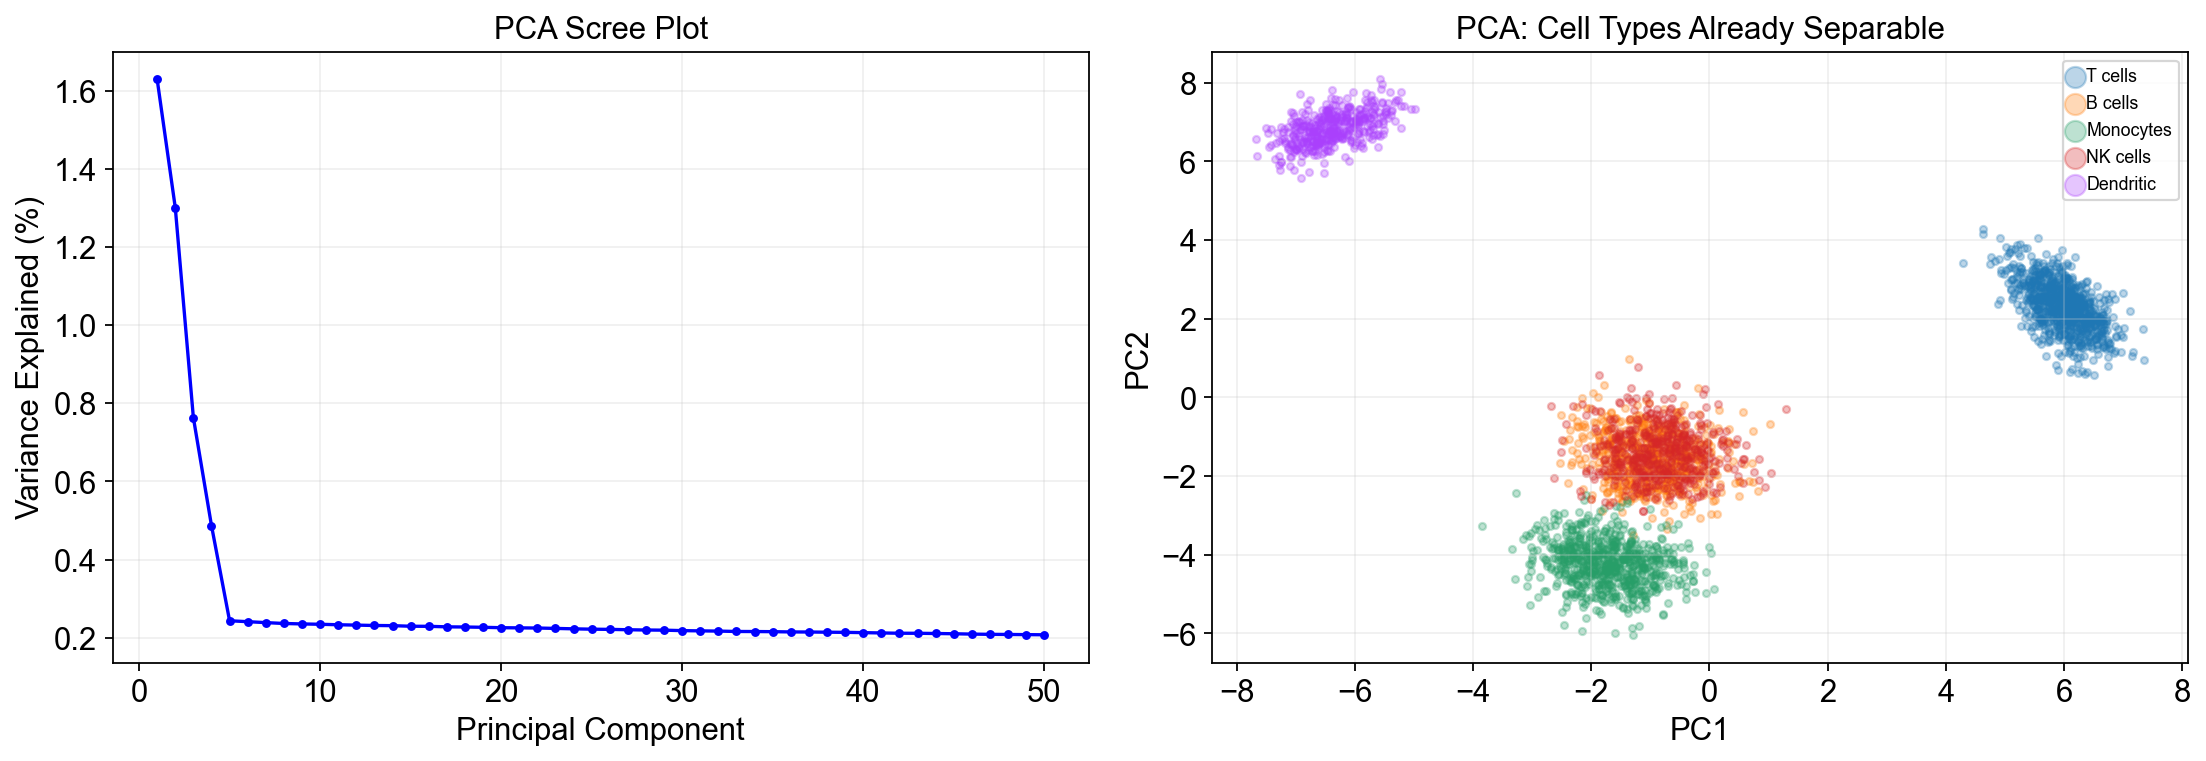

In [8]:
# Subset to HVGs for dimensionality reduction
adata_hvg = adata[:, adata.var['highly_variable']].copy()

# Scale to unit variance
sc.pp.scale(adata_hvg, max_value=10)

# PCA (50 components)
sc.tl.pca(adata_hvg, n_comps=50)

# Variance explained
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, 51), adata_hvg.uns['pca']['variance_ratio'] * 100, 'bo-', markersize=3)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained (%)')
ax1.set_title('PCA Scree Plot')
ax1.grid(True, alpha=0.3)

# Color by cell type in PC space
for ct in cell_type_names:
    mask = adata_hvg.obs['cell_type'] == ct
    ax2.scatter(adata_hvg.obsm['X_pca'][mask, 0], adata_hvg.obsm['X_pca'][mask, 1],
               alpha=0.3, s=10, label=ct)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title('PCA: Cell Types Already Separable')
ax2.legend(markerscale=3, fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 3: UMAP and Clustering

UMAP (Uniform Manifold Approximation and Projection) creates a 2D embedding that preserves
local neighborhood structure. Cells near each other in UMAP space have similar gene expression
profiles.

Leiden clustering finds communities in the cell-cell nearest neighbor graph.
See [[Trajectory and Branching Fate]] -- clusters often correspond to cell states along
differentiation trajectories.

In [9]:
# Build nearest neighbor graph
sc.pp.neighbors(adata_hvg, n_neighbors=15, n_pcs=30)

# UMAP embedding
sc.tl.umap(adata_hvg)

# Leiden clustering
sc.tl.leiden(adata_hvg, resolution=0.5)

print(f"Leiden clusters found: {adata_hvg.obs['leiden'].nunique()}")
print(f"Cluster sizes:\n{adata_hvg.obs['leiden'].value_counts()}")

Leiden clusters found: 5
Cluster sizes:
leiden
0    800
1    700
2    600
3    500
4    400
Name: count, dtype: int64


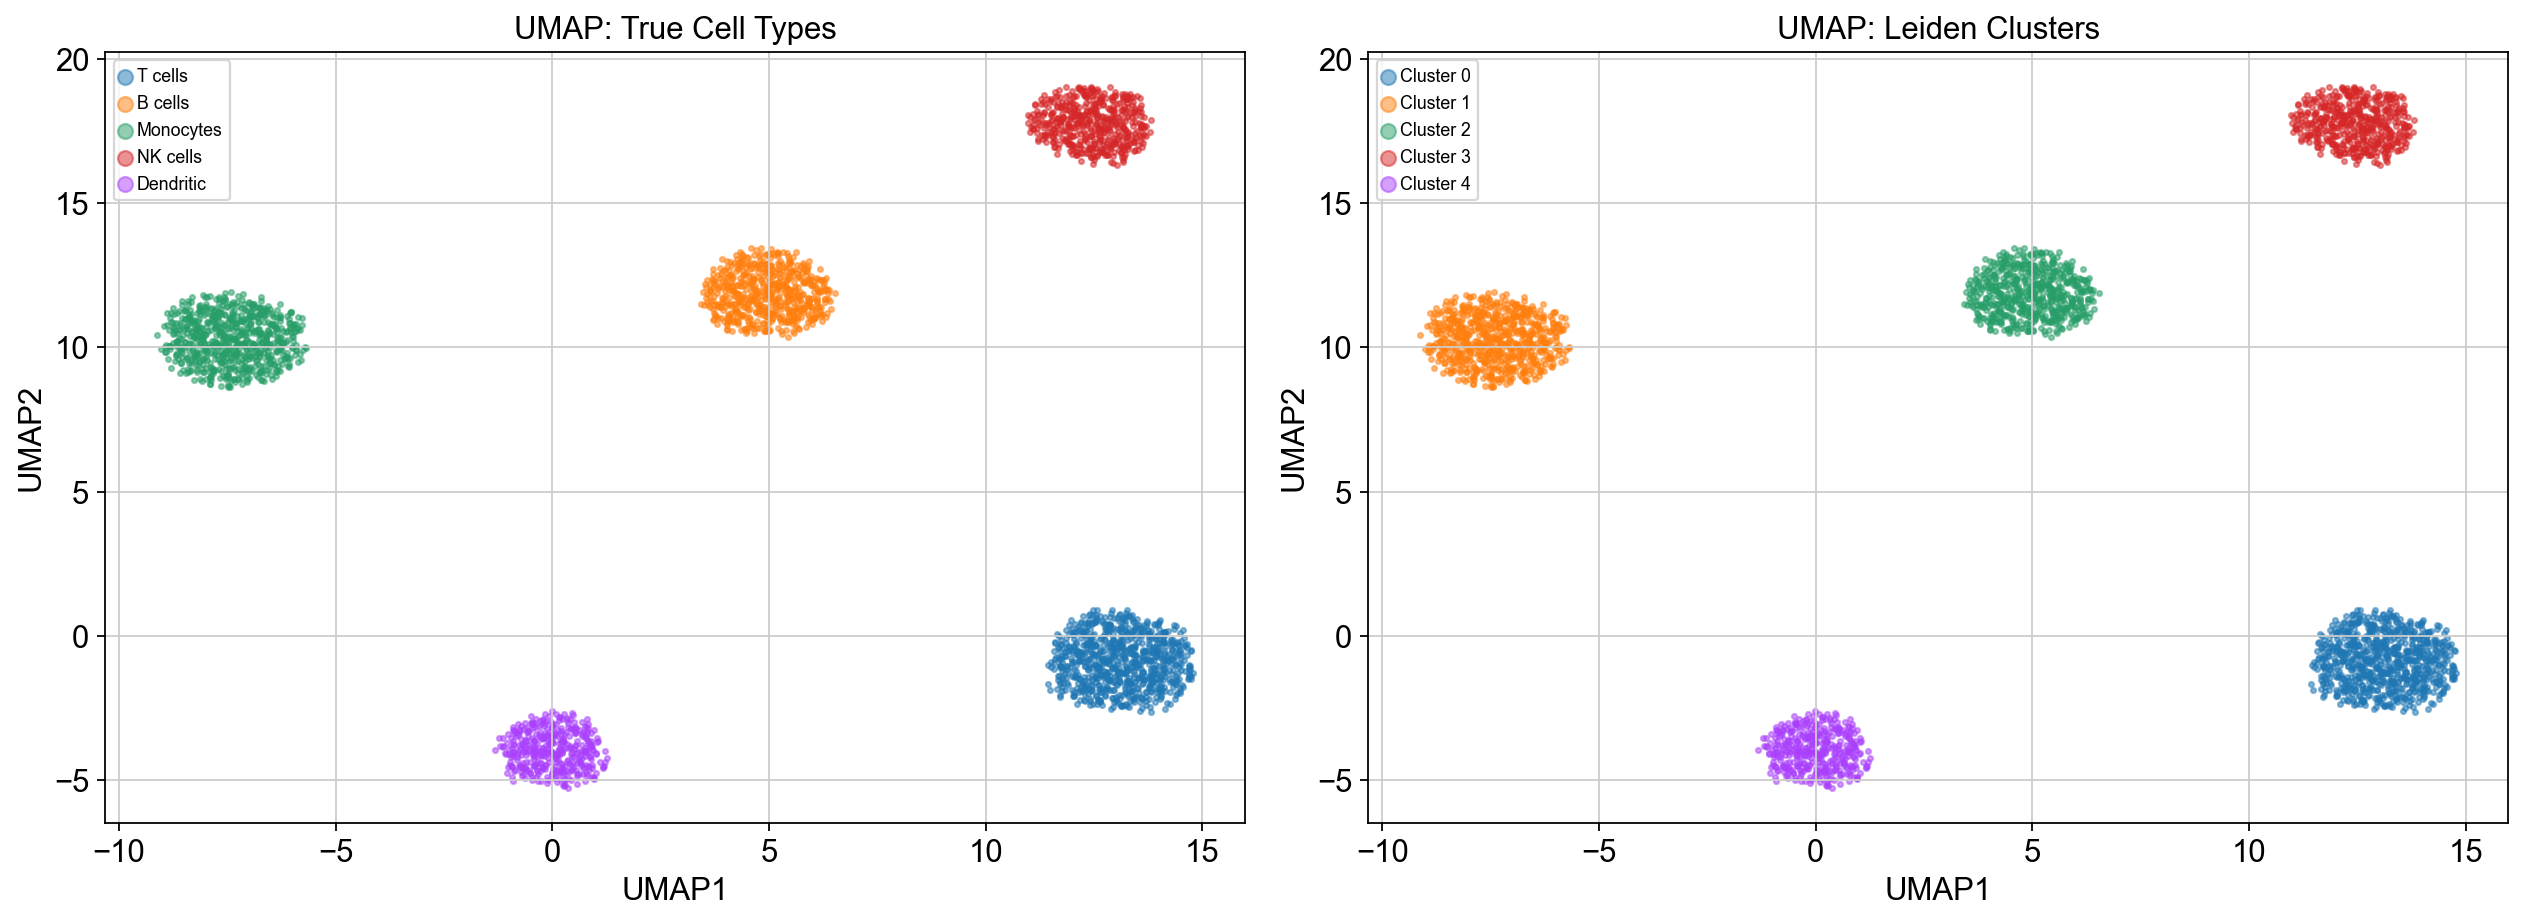

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Color by true cell type
for ct in cell_type_names:
    mask = adata_hvg.obs['cell_type'] == ct
    axes[0].scatter(adata_hvg.obsm['X_umap'][mask, 0], adata_hvg.obsm['X_umap'][mask, 1],
                   alpha=0.5, s=5, label=ct)
axes[0].set_title('UMAP: True Cell Types')
axes[0].legend(markerscale=3, fontsize=8)
axes[0].set_xlabel('UMAP1')
axes[0].set_ylabel('UMAP2')

# Color by Leiden clusters
for cl in sorted(adata_hvg.obs['leiden'].unique(), key=int):
    mask = adata_hvg.obs['leiden'] == cl
    axes[1].scatter(adata_hvg.obsm['X_umap'][mask, 0], adata_hvg.obsm['X_umap'][mask, 1],
                   alpha=0.5, s=5, label=f'Cluster {cl}')
axes[1].set_title('UMAP: Leiden Clusters')
axes[1].legend(markerscale=3, fontsize=8)
axes[1].set_xlabel('UMAP1')
axes[1].set_ylabel('UMAP2')

plt.tight_layout()
plt.show()

Cluster composition (% of each cell type per cluster):
cell_type  B cells  Dendritic  Monocytes  NK cells  T cells
leiden                                                     
0              0.0        0.0        0.0       0.0    100.0
1              0.0        0.0      100.0       0.0      0.0
2            100.0        0.0        0.0       0.0      0.0
3              0.0        0.0        0.0     100.0      0.0
4              0.0      100.0        0.0       0.0      0.0


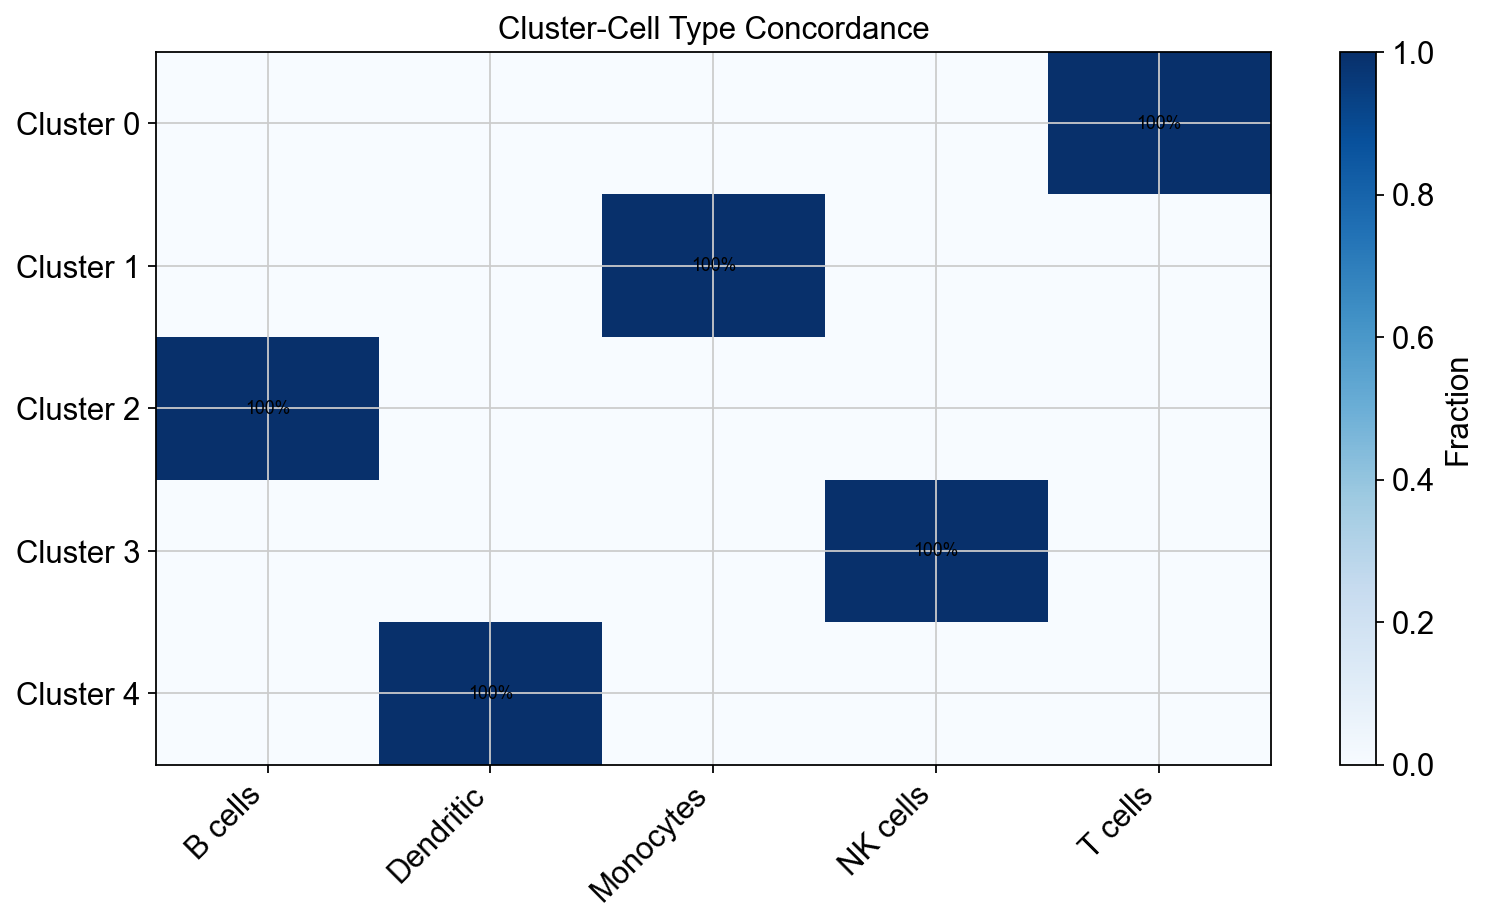

In [11]:
# Cross-tabulation: do clusters match cell types?
ct = pd.crosstab(adata_hvg.obs['leiden'], adata_hvg.obs['cell_type'], normalize='index')
print("Cluster composition (% of each cell type per cluster):")
print((ct * 100).round(1))

# Heatmap
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(ct.values, cmap='Blues', aspect='auto')
ax.set_xticks(range(len(ct.columns)))
ax.set_xticklabels(ct.columns, rotation=45, ha='right')
ax.set_yticks(range(len(ct.index)))
ax.set_yticklabels([f'Cluster {i}' for i in ct.index])
plt.colorbar(im, label='Fraction')
ax.set_title('Cluster-Cell Type Concordance')

# Add text annotations
for i in range(len(ct.index)):
    for j in range(len(ct.columns)):
        val = ct.values[i, j]
        if val > 0.1:
            ax.text(j, i, f'{val:.0%}', ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()

## Section 4: Differential Expression and Marker Genes

Marker genes are differentially expressed in one cluster vs all others. They are the
molecular signatures that define cell types. See [[Signal Processing in Biological Systems]].

The Wilcoxon rank-sum test compares expression distributions:
$$H_0: \text{Expression}_{\text{cluster}} = \text{Expression}_{\text{rest}}$$

In [12]:
# Rank genes by differential expression (Wilcoxon)
sc.tl.rank_genes_groups(adata_hvg, 'leiden', method='wilcoxon')

# Show top markers per cluster
print("Top 5 marker genes per cluster:")
result = adata_hvg.uns['rank_genes_groups']
for cl in sorted(adata_hvg.obs['leiden'].unique(), key=int):
    genes = result['names'][cl][:5]
    scores = result['scores'][cl][:5]
    print(f"\n  Cluster {cl}:")
    for g, s in zip(genes, scores):
        print(f"    {g}: score = {s:.2f}")

Top 5 marker genes per cluster:

  Cluster 0:
    GENE_0013: score = 41.94
    TCF7: score = 41.94
    GENE_0012: score = 41.94
    CD8A: score = 41.94
    TRAC: score = 41.94

  Cluster 1:
    VCAN: score = 40.12
    S100A9: score = 40.12
    GENE_0078: score = 40.11
    GENE_0070: score = 40.11
    FCN1: score = 40.11

  Cluster 2:
    GENE_0045: score = 37.94
    CD79A: score = 37.94
    GENE_0041: score = 37.94
    CD19: score = 37.94
    GENE_0047: score = 37.94

  Cluster 3:
    GENE_0098: score = 35.35
    GENE_0097: score = 35.35
    GENE_0099: score = 35.35
    GENE_0109: score = 35.34
    NKG7: score = 35.34

  Cluster 4:
    GENE_0136: score = 32.24
    GENE_0138: score = 32.24
    CD1C: score = 32.24
    GENE_0126: score = 32.24
    IRF8: score = 32.24


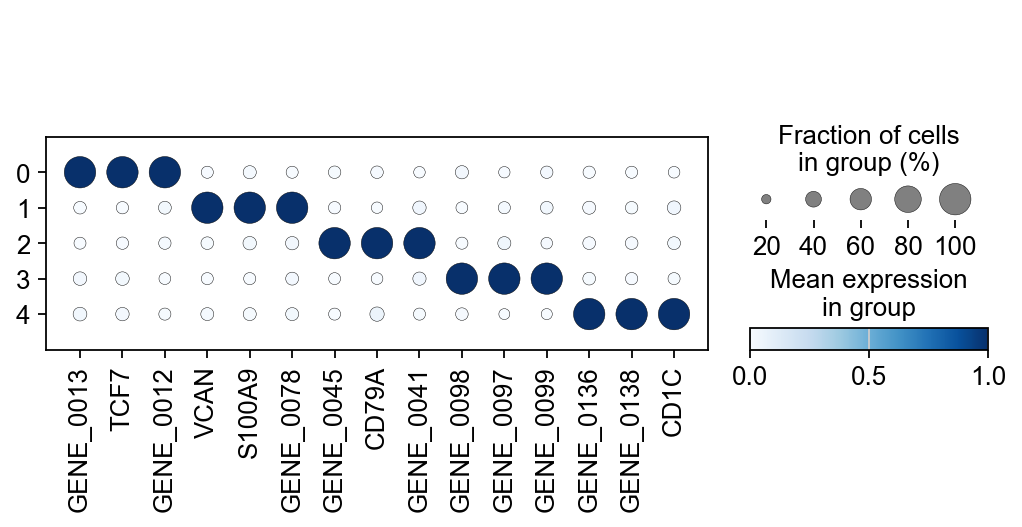

In [13]:
# Get top 3 markers per cluster
top_markers = []
for cl in sorted(adata_hvg.obs['leiden'].unique(), key=int):
    genes = result['names'][cl][:3]
    top_markers.extend(genes)

# Remove duplicates while preserving order
seen = set()
unique_markers = []
for g in top_markers:
    if g not in seen:
        seen.add(g)
        unique_markers.append(g)

sc.pl.dotplot(adata_hvg, unique_markers, groupby='leiden',
              standard_scale='var', cmap='Blues')
plt.show()

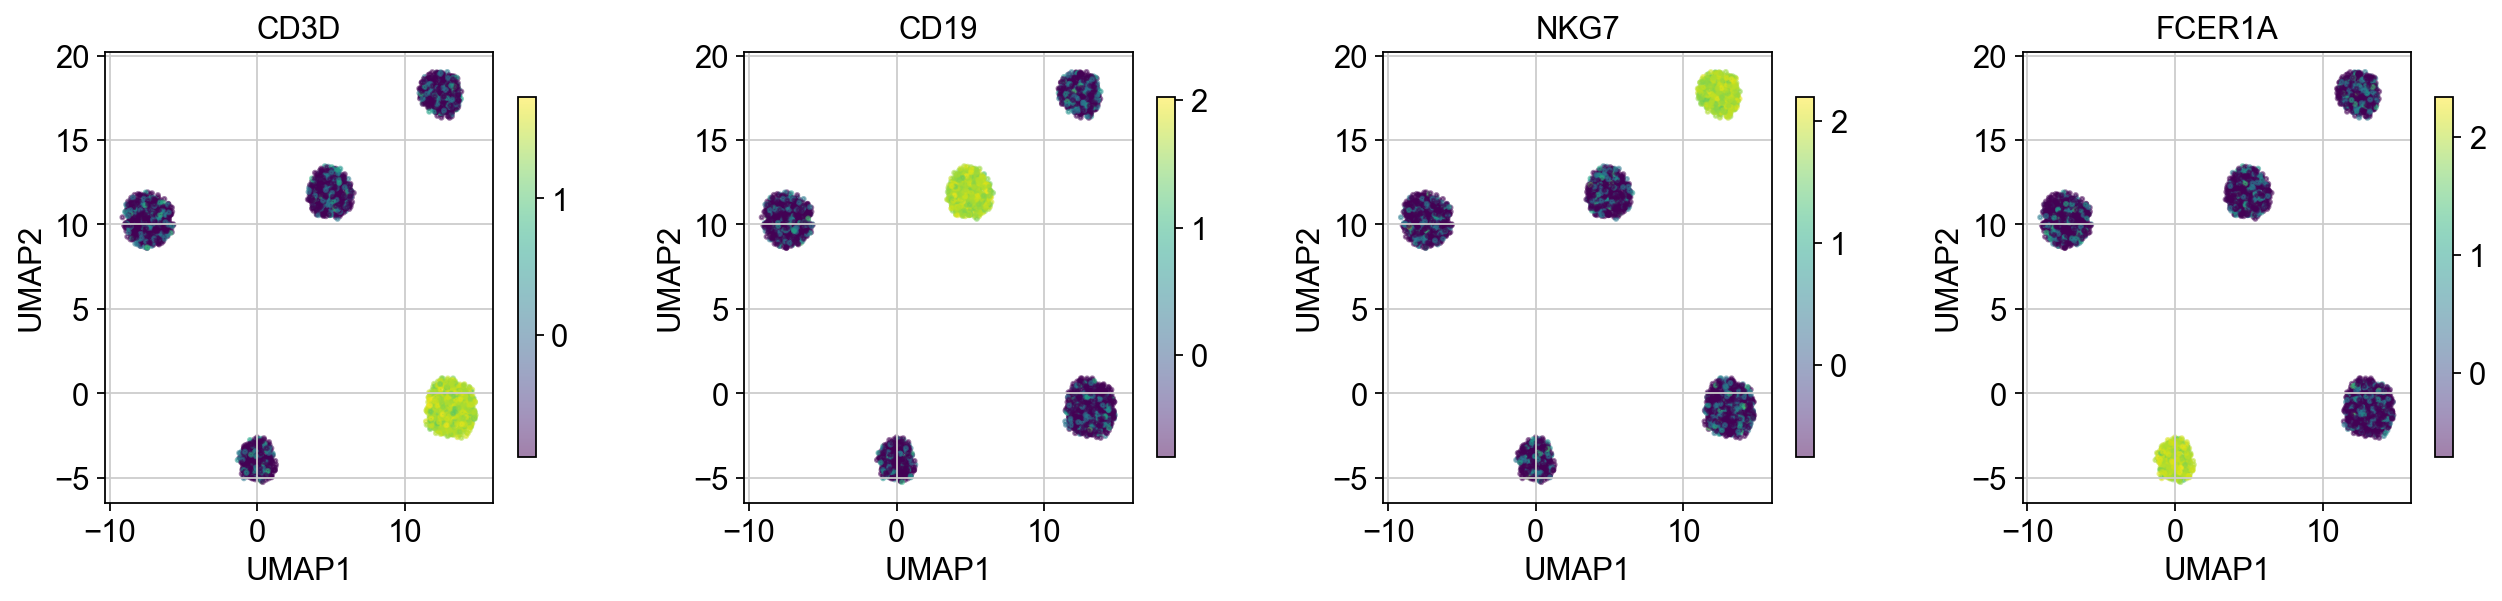

In [14]:
# Plot key marker genes on UMAP
key_markers = ['CD3D', 'CD19', 'CD14', 'NKG7', 'FCER1A']
available_markers = [m for m in key_markers if m in adata_hvg.var_names]

if len(available_markers) >= 4:
    fig, axes = plt.subplots(1, len(available_markers), figsize=(4*len(available_markers), 4))
    for ax, gene in zip(axes, available_markers):
        gene_idx = list(adata_hvg.var_names).index(gene)
        expr = adata_hvg.X[:, gene_idx]
        if hasattr(expr, 'toarray'):
            expr = expr.toarray().flatten()
        scatter = ax.scatter(adata_hvg.obsm['X_umap'][:, 0], adata_hvg.obsm['X_umap'][:, 1],
                           c=expr, s=3, alpha=0.5, cmap='viridis')
        ax.set_title(gene)
        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        plt.colorbar(scatter, ax=ax, shrink=0.8)
    plt.tight_layout()
    plt.show()
else:
    print(f"Available markers: {available_markers}")
    print("Using generic marker gene visualization")

## Section 5: Cell Type Annotation

Manual annotation assigns biological names to clusters based on marker genes.
In practice, this requires domain knowledge. Automated annotation tools (CellTypist, scType)
use reference databases. See [[Single-Cell Foundation Models]] and [[Foundation Models in Biology]].

This step exemplifies [[Context Conditionality]] -- the same gene can mark different cell types
depending on co-expression context. [[Degeneracy in Biological Systems]] applies: many different
gene combinations can produce the same cell phenotype.

In [15]:
# Map clusters to cell types based on marker expression
# In practice, you'd look at marker genes and use domain knowledge
cluster_to_type = {}
for cl in sorted(adata_hvg.obs['leiden'].unique(), key=int):
    # Find the dominant cell type
    mask = adata_hvg.obs['leiden'] == cl
    dominant = adata_hvg.obs.loc[mask, 'cell_type'].value_counts().index[0]
    cluster_to_type[cl] = dominant

adata_hvg.obs['annotated_type'] = adata_hvg.obs['leiden'].map(cluster_to_type)

print("Cluster annotations:")
for cl, ct in sorted(cluster_to_type.items(), key=lambda x: int(x[0])):
    n = (adata_hvg.obs['leiden'] == cl).sum()
    print(f"  Cluster {cl} -> {ct} ({n} cells)")

# Accuracy
correct = (adata_hvg.obs['annotated_type'] == adata_hvg.obs['cell_type']).mean()
print(f"\nAnnotation accuracy: {correct:.1%}")

Cluster annotations:
  Cluster 0 -> T cells (800 cells)
  Cluster 1 -> Monocytes (700 cells)
  Cluster 2 -> B cells (600 cells)
  Cluster 3 -> NK cells (500 cells)
  Cluster 4 -> Dendritic (400 cells)

Annotation accuracy: 100.0%


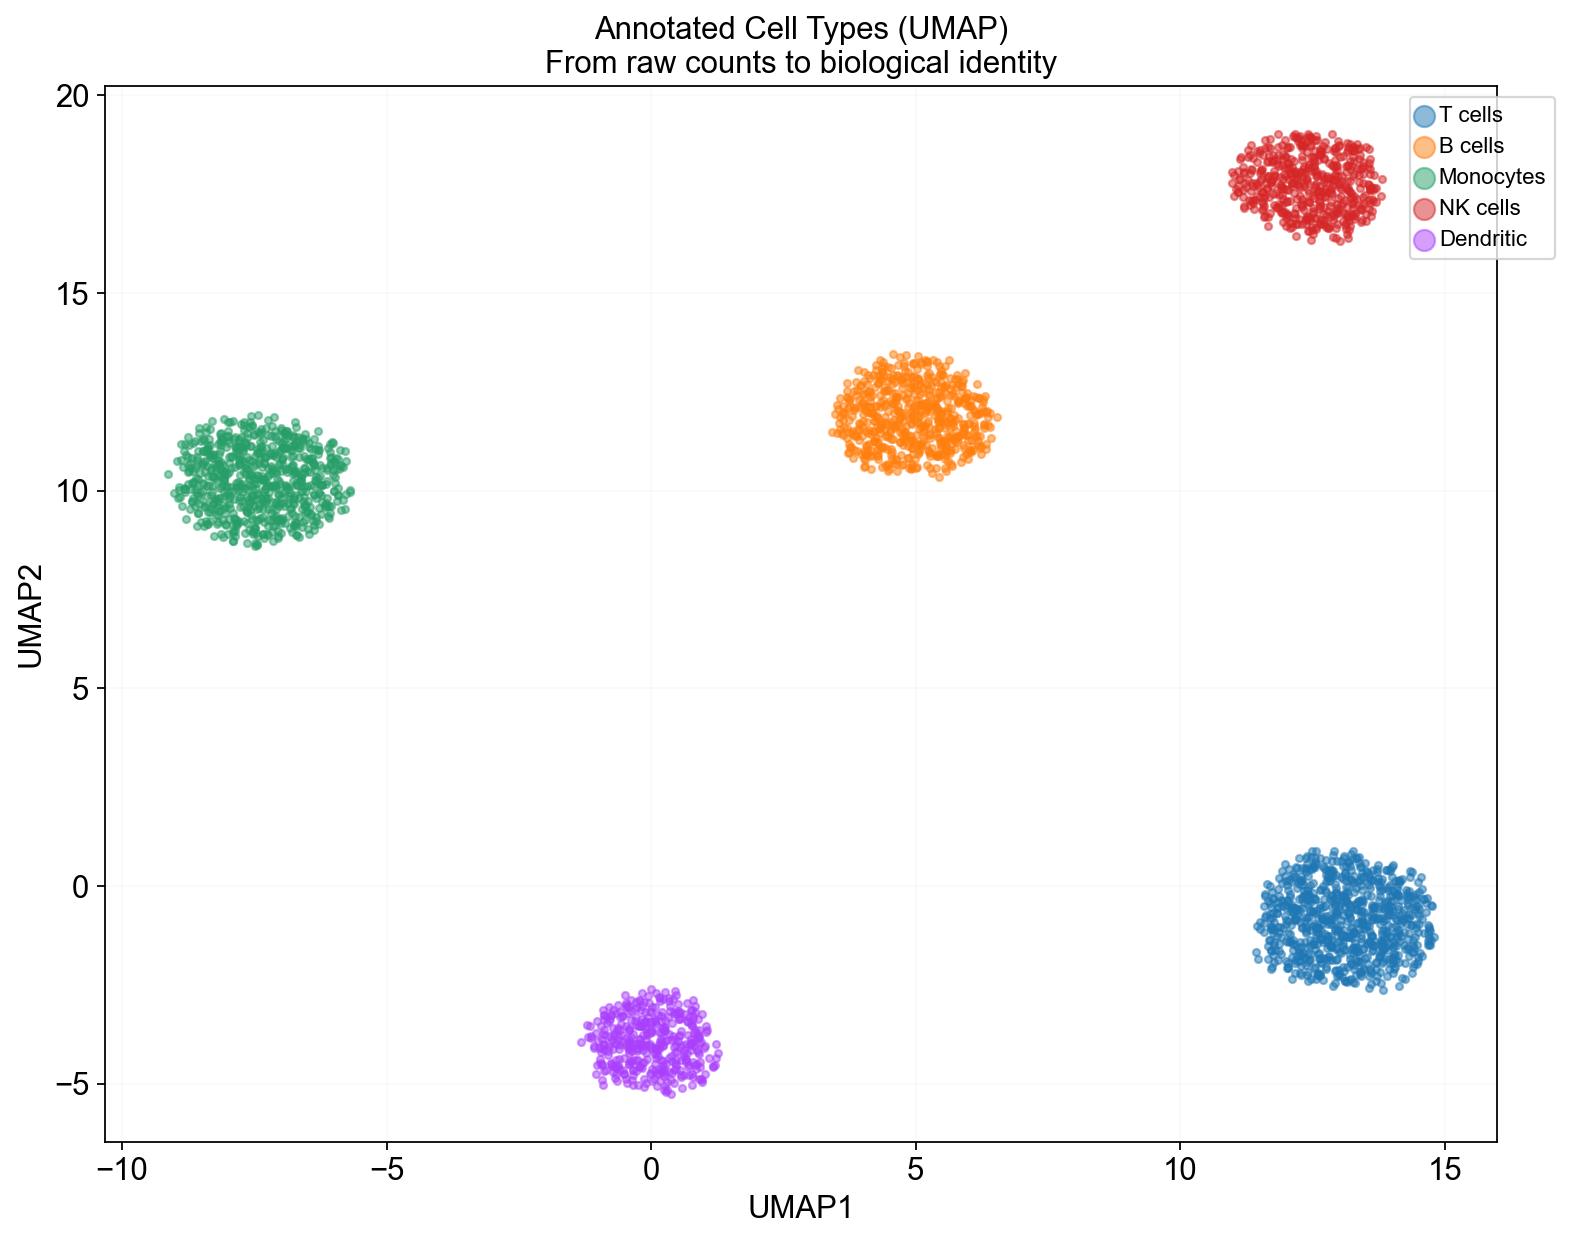

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

for ct in cell_type_names:
    mask = adata_hvg.obs['annotated_type'] == ct
    ax.scatter(adata_hvg.obsm['X_umap'][mask, 0], adata_hvg.obsm['X_umap'][mask, 1],
              alpha=0.5, s=10, label=ct)

ax.set_title('Annotated Cell Types (UMAP)\nFrom raw counts to biological identity', fontsize=14)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.legend(markerscale=3, fontsize=10, bbox_to_anchor=(1.05, 1))
ax.grid(True, alpha=0.1)
plt.tight_layout()
plt.show()

## Summary

| Concept | What you built | Why it matters |
|---------|---------------|----------------|
| AnnData | cells x genes matrix | Standard single-cell data structure |
| QC filtering | Dead cell removal | Prevent artifacts from dead/doublet cells |
| Normalization | Library size + log1p | Makes cells comparable |
| HVG selection | Top 1000 variable genes | Focus on informative features |
| PCA | 50 components | Denoise and compress |
| UMAP | 2D embedding | Visualize high-dimensional landscape |
| Leiden clustering | Community detection | Unsupervised cell grouping |
| Marker genes | Wilcoxon rank-sum | Define cell type signatures |
| Annotation | Cluster -> cell type | [[Context Conditionality]] of gene function |

**Connections to conceptual framework:**
- [[Hierarchical Composition]]: AnnData captures molecule -> cell level
- [[Trajectory and Branching Fate]]: Clusters map to cell states
- [[Context Conditionality]]: Same gene, different meaning in different cells
- [[Degeneracy in Biological Systems]]: Many gene programs -> same phenotype
- [[Information Compression in Biology]]: HVG selection as lossy compression

**Next**: [[04_Protein_Structure_Drug_Discovery]] -- from sequence to 3D structure and drug design